<a href="https://colab.research.google.com/github/sunRise9551/Building_Makemore/blob/main/Makemore_Backprop_Ninja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# there no change change in the first several cells from last lecture

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-09-20 13:52:54--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-09-20 13:52:54 (7.27 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# ok biolerplate done, now we get to the action:

In [54]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [55]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.5571, grad_fn=<NegBackward0>)

# Derivatives

## dlogprobs / dloss

Working line


In [12]:
loss = -logprobs[range(n), Yb].mean()

In [13]:
Yb

tensor([ 1,  0, 25, 12,  9,  9,  0,  0, 13, 25, 13, 18, 25, 14, 12,  9, 12, 15,
         5, 15, 14,  0,  5,  1, 15, 25, 20,  8,  1,  1, 15,  0])

In [14]:
-logprobs[range(n), Yb]

tensor([3.8106, 2.6852, 3.5044, 3.5740, 3.7504, 3.2781, 3.0362, 3.9446, 3.4031,
        2.9343, 3.4031, 4.1493, 3.0322, 3.7628, 2.9034, 3.0381, 3.2786, 4.1927,
        3.8432, 3.6620, 3.3188, 2.9225, 3.3225, 4.2062, 3.5622, 4.0472, 3.8938,
        3.4679, 4.4514, 4.3026, 3.4206, 3.7267], grad_fn=<NegBackward0>)

    loss = -logprobs[range(n), Yb].mean()
    loss = - (a + b + c) / 3
    loss = -1/3a +-1/3b +-1/3c
    
    dlogprobs = ???

    dloss/da = -1/3
    dloss/db = -1/3
    dloss/dc = -1/3

    dlogprobs = -1/n

In [15]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


## dprobs / dlogprobs

Working line


In [16]:
logprobs = probs.log()

    logprobs = probs.log()

    dprobs = ???

    dprobs = (Local) * (Ouput)
    dprobs = (log) * (dlogprobs)
    dprobs = (1/probs) * (dlogprobs)



In [17]:
dprobs = (1/probs) * (dlogprobs)
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


## dcounts_sum_inv / dprobs

In [18]:
probs = counts * counts_sum_inv

In [19]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [20]:
# c = a * b, but with tensors:
# a[3x2] * b[3,1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a23*b3 a33*b3
# c[3x3]

    probs = counts * counts_sum_inv

    dcounts_sum_inv = ???

    dcounts_sum_inv = (Local) * (Output)
    dcounts_sum_inv = (counts) * (dprobs) <-- Local for multiplication is another data(which is 'counts' here)
    dcounts_sum_inv = ((counts) * (dprobs)).sum(1, keepdim=True)

In [21]:
dcounts_sum_inv = ((counts) * (dprobs)).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


## dcounts / dprobs (1st Branch)

In [22]:
probs = counts * counts_sum_inv

    probs = counts * counts_sum_inv

    dcounts = ???

    dcounts = (Local) * (Output)
    dcounts = (counts_sum_inv) * (dprobs)

In [23]:
dcounts = (counts_sum_inv) * (dprobs)

Cannot check yet, because:

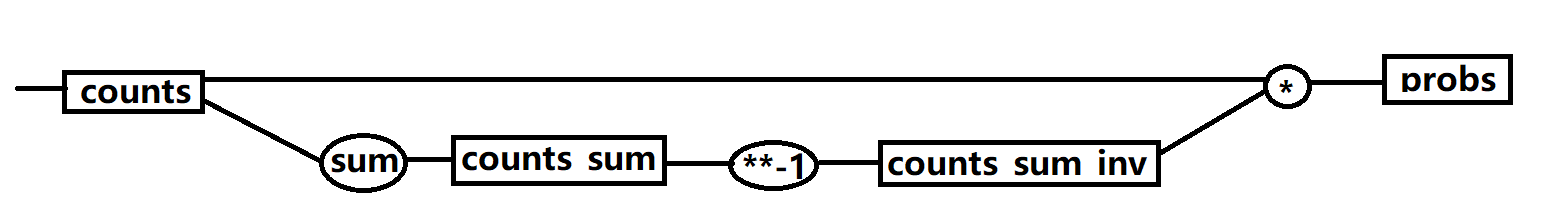

## dcounts_sum / dcounts_sum_inv

In [24]:
counts_sum_inv = counts_sum**-1

    counts_sum_inv = counts_sum**-1

    dcounts_sum = ???

    counts_sum**-1
    = a**-1
    = 1/a
    = 1/a^2

    dcounts_sum = (Local) * (Output)
    dcounts_sum = (1/counts_sum**2) * (dcounts_sum_inv)

In [25]:
# dcounts_sum = (-counts_sum**-2) * (dcounts_sum_inv)
dcounts_sum = (-1/counts_sum**2) * (dcounts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


## dcounts / dcounts_sum

Working line

In [26]:
counts_sum = counts.sum(1, keepdims=True)

Code: Summing up all the counts, in rows

In [27]:
# counts_sum = b1(= a11 + a12 + a13)

# a11 a12 a13 ---> b1(= a11 + a12 + a13)
# a21 a22 a23 ---> b2(= a21 + a22 + a23)
# a31 a23 a33 ---> b3(= a31 + a32 + a33)

- We now have the derivatives of loss with respect to b1, b2, b3, ...

- We want the derivatives of loss with respect to a11, a12, a13, a21, ...

- In other way, how do b1, b2 depends on a11, etc.

- b1 will only depends on (a11 + a12 + a13)
- Local derivative for Addition is always 1

    counts_sum = counts.sum(1, keepdims=True)

    dcounts = ???

    dcounts = (Local) * (Input)
    dcounts = (torch.ones_like(counts)) * (dcounts_sum)

In [28]:
dcounts += (torch.ones_like(counts)) * (dcounts_sum)
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


## dnorms_logits / dcounts

Working line:

In [29]:
counts = norm_logits.exp()

    counts = norm_logits.exp()

    dnorm_logits = ???

    dnorm_logits = (Local) * (Input)
    dnorm_logits = (norm_logits.exp()) * (dcounts)
    dnorm_logits = (counts) * (dcounts)

In [30]:
dnorm_logits = (counts) * (dcounts)
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


## dlogit_maxes / dnorm_logits

Working line:

In [31]:
norm_logits = logits - logit_maxes

In [32]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [33]:
# c11 c12 c13 ---> a11 + a12 + a13   b1
# c21 c22 c23 ---> a21 + a22 + a23 - b2
# c31 c23 c33 ---> a31 + a32 + a33   b3

# so e.g. c32 = a32 - b3

    norm_logits = logits - logit_maxes
         c32    =   a32  -     b3

    dlogit_maxes = ???  equivalent to db3 = ???

    dlogit_maxes = (Local) * (Output)
    dlogit_maxes = (-b3) * (dnorm_logits)
    dlogit_maxes = (-1) * (dnorm_logits)
    dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) <-- Sum all across row

In [34]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


## dlogits / dnorm_logits (1st Branch)


Working line:

In [35]:
norm_logits = logits - logit_maxes

    dlogits = ???

    dlogits = (Local) * (Output)
    dlogits = (1.0) * (dnorm_logits)

In [36]:
# Clone for Safety
# dlogits = dnorm_logits

In [37]:
dlogits = dnorm_logits.clone()

## dlogits / dlogit_maxes (2nd Branch)

Working Line:

In [38]:
logit_maxes = logits.max(1, keepdim=True).values

In [39]:
logits.max(1, keepdim=True) # Run this, check shape

torch.return_types.max(
values=tensor([[0.8246],
        [0.8141],
        [1.0546],
        [1.0278],
        [0.6458],
        [0.9713],
        [0.9068],
        [1.0532],
        [1.0546],
        [0.8698],
        [1.0546],
        [1.1950],
        [0.9470],
        [1.3395],
        [1.3584],
        [1.0546],
        [1.0546],
        [1.2984],
        [1.1255],
        [1.1828],
        [0.9337],
        [1.2490],
        [0.9182],
        [0.9998],
        [0.6766],
        [0.8860],
        [1.3508],
        [0.8151],
        [1.0546],
        [0.9669],
        [1.3821],
        [1.5415]], grad_fn=<MaxBackward0>),
indices=tensor([[25],
        [ 0],
        [22],
        [ 5],
        [10],
        [23],
        [ 3],
        [19],
        [22],
        [ 4],
        [22],
        [15],
        [22],
        [ 0],
        [ 5],
        [22],
        [22],
        [19],
        [22],
        [19],
        [24],
        [13],
        [13],
        [12],
        [24],
        [

In [40]:
# dlogits = (dlogits * dlogit_maxes)

In [41]:
# max_indices = logits.max(1, keepdim=True)[1] # <-- TODO: FIX
# dlogits[range(n), Yb] += 1 * (dlogit_maxes)

# dlogits = torch.zeros_like(logits)
# dlogits[range(logits.shape[0]), logits.max(1).indices] = 1 # Turning on the 1

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


## dh / dlogits

Working line:

In [42]:
logits = h @ W2 + b2

In [43]:
logits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [44]:
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


## dW2 / dlogits

In [45]:
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


## db2 / dlogits

In [46]:
db2 = dlogits.sum(0)
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


## dhpreact / dh

Working line:

In [47]:
h = torch.tanh(hpreact)

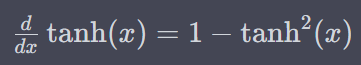

In [48]:
dhpreact = (1 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


dbngain / dhpreact

In [49]:
hpreact = bngain * bnraw + bnbias

In [50]:
dhpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [51]:
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
cmp('bngain', dbngain, bngain)

bngain          | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09


## dbnraw / dhpreact

In [58]:
dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## dbnbias / dhpreact

In [59]:
dbnbias = dhpreact.sum(0, keepdims=True)
cmp('bnbias', dbnbias, bnbias)

bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


## dbndiff / dbnraw (1st Branch)

In [61]:
bnraw = bndiff * bnvar_inv

In [62]:
dbnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [63]:
dbndiff = bnvar_inv * bnraw
# cmp('bndiff', dbndiff, bndiff) # 1st Branch

bndiff          | exact: False | approximate: False | maxdiff: 3.100727081298828


## dbnvar_inv / dbnraw

In [64]:
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-09


## dbnvar / dbnvar_inv

In [ ]:
bnvar_inv = (bnvar + 1e-5)**-0.5

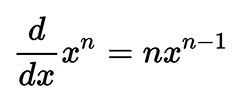

In [66]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## dbndiff2 / dbnvar

In [ ]:
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)

# Exercise 1

In [56]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
